# FIRST TASK

## Preliminary steps

Import the libraries

In [287]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

Utility functions:
- **plot_images** : plots the images
- **get_img_filenames** : to generate the images filenames

In [222]:
def plot_images(images,title="",color=False,rgb=True):
    for i in range(len(images)):
        plt.subplot(1,N,i+1).axis("off")
        if color and rgb : 
            plt.imshow(images[i])
        elif color and rgb==False:
            plt.imshow(cv.cvtColor(images[i],cv.COLOR_BGR2RGB))
        else:
            plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.show()

def get_img_filenames(task):
    nir_img_filenames = []
    rgb_img_filenames = []
    for y in range(1,4):
        nir_img_filenames.append("../imgs/{}/C0_00000{}.png".format(task,y))
        rgb_img_filenames.append("../imgs/{}/C1_00000{}.png".format(task,y))
    return nir_img_filenames, rgb_img_filenames

nir_img_filenames, rgb_img_filenames = get_img_filenames("first_task")
N = len(nir_img_filenames)

Reading the images

In [288]:
nir_img = []
rgb_img = []
for i in range(N):
    nir_img.append(cv.imread(nir_img_filenames[i],0))
    rgb_img.append(cv.imread(rgb_img_filenames[i]))

## Create a **Binary Mask** to outline the fruits

I threshold the whole image in order to remove the background. 

First, I used a global thresholding approach, using Otsu's method to calculate the threshold.

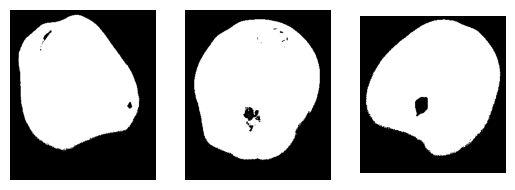

In [289]:
im_th = []

for i in range(N):
    _, im_thresh = cv.threshold(nir_img[i],None,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    im_th.append(im_thresh)
plot_images(im_th)    

As you can see in the image above, it works pretty well, but it isn't a super accurate segmentation because some parts of the apples are considered as backgorund. For example, in first and third image the stalk of the apple and the region around are not considered as foreground. For some applications this segmentation can be enough, but I decided to detect more accurately the shapes of the apples.

This is because the light isn't uniform in the images.

For this reason I decided to use **ADAPTIVE THRESHOLDING** which compute a binarization threshold at each image pixel, based on the intensities within a small neighbourhood. This type of thresholding can handle also images without uniform lighting across the scene.

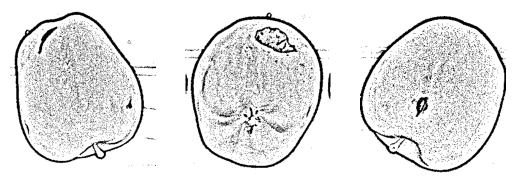

In [290]:
im_th = []
filled = []
for i in range(N):
    im_th.append(cv.adaptiveThreshold(nir_img[i],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,15,3))

plot_images(im_th)

inverto l'immagine ...

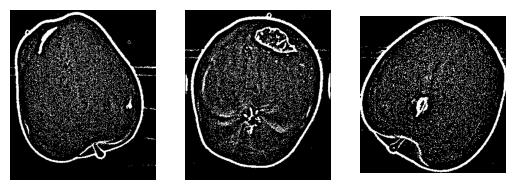

In [291]:
for i in range(N):
    im_th[i] = cv.bitwise_not(im_th[i])
plot_images(im_th)

applico filtro mediano per togliere un po di rumore salt and pepper

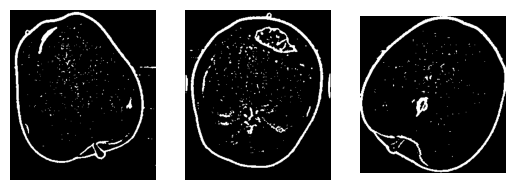

In [292]:
for i in range(N):
    im_th[i] = cv.medianBlur(im_th[i],3)
plot_images(im_th)

Considerando larea della bounding box, dopo il backgoround, il connected components con la bounding box di area maggiore sarà per forza quello associato alla mela. Per questo motivo possiamo coniderare, escludendo il background, i bordi della mela come il connected components con area della bounding box maggiore. Potevo considerare anche l'area in pixel del connected components ma nel caso di grossi difetti questi potevano avere un'area maggiore, se oltre al bordo era piu scuro anche l'interno. Per questo motivo ho preferito calcolarmi larea della bounding box piuttosto che utilizzare l'area fornita dalla funzione connectedComponentsWithStats.
 

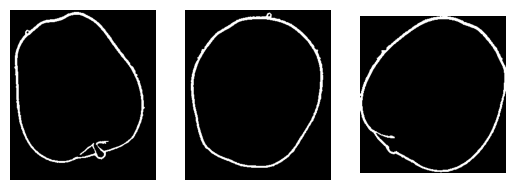

In [293]:
binary_mask = []
for i in range(N):
    (numLabels, labels, stats, _) = cv.connectedComponentsWithStats(im_th[i], 4)
    max_area = -np.inf
    j_mask = -1
    for j in range(1,numLabels):
        w = stats[j, cv.CC_STAT_WIDTH]
        h = stats[j, cv.CC_STAT_HEIGHT]
        area_bbox = h*w
        if (area_bbox>max_area):
            max_area = area_bbox
            j_mask = j
    binary_mask.append((labels == j_mask).astype("uint8") * 255)
plot_images(binary_mask)

**FILLING THE SPACE INSIDE THE FRUIT BLOB USING A FLOOD FILL APPROACH**

The **cv.floodFill** function fills a connected component starting from the seed point with the specified color.  
This function requires an operation mask that should be a single-channel 8-bit image, 2 pixels wider and 2 pixels taller than image. 

Partiamo dal pressupposto che la mela sia tutta ben inqudrata dalla telecamera, e che riempa gran parte dell'immagine, quindi il pixel centrale sarà per forza parte della mela. A partire da tale punto facciamo flood fill riempendo la mela e ottenendo cosi la maschera binaria

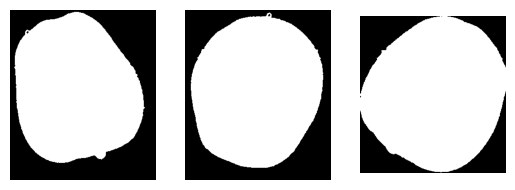

In [294]:
op_mask = []
for i in range(N):
    h, w = binary_mask[i].shape[:2]
    op_mask.append(np.zeros((h+2, w+2), np.uint8))
    cv.floodFill(binary_mask[i], op_mask[i], (125,125), 255)
plot_images(binary_mask)

Apply the mask to the nir image

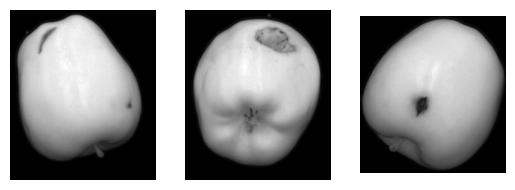

In [295]:
nir_fruit = []
for i in range(N):
    nir_fruit.append(cv.bitwise_and(nir_img[i],nir_img[i],mask=refined_mask[i]))
plot_images(nir_fruit,color=True,rgb=False)

Find and draw the contours of the fruit, on the colour image

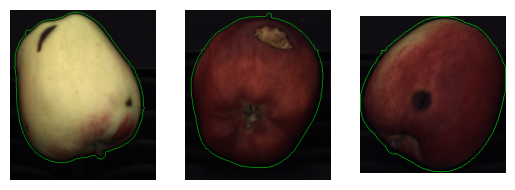

In [296]:
contours = []

for i in range(N):
    cont, _ =  cv.findContours(refined_mask[i], cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    contours.append(cont)
    cv.drawContours(rgb_img[i], contours[i], -1, (0,255,0), 1)

plot_images(rgb_img,color=True,rgb=False)



## Defects search

I filter the image of the fruit obtained after applying the binary mask. Then I use **Canny** to detect edges.

Without filtering the image before applying Canny, we notice that there're a lot of spurious edges not correlated with fruit contours or defects' contours.

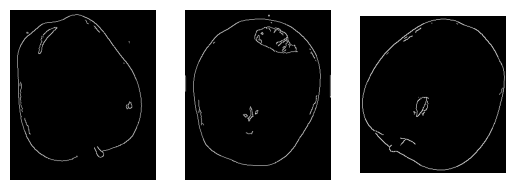

In [297]:
edges = []
for i in range(N): 
    edges.append(cv.Canny(nir_img[i],60,120))

plot_images(edges)

Applying a bilateral filter before Canny, only fruit external edges and defects edges appears.

I use a **Bilateral Filter** to denoise the image, without blurring the edges.

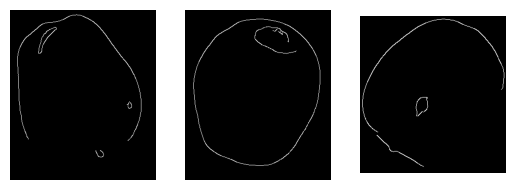

In [299]:
d = 9
sigma = 50
blurred_nir_fruit = []
for i in range(N):
    blurred_nir_fruit.append(cv.bilateralFilter(nir_fruit[i],d,sigma,sigma))
    edges[i] = cv.Canny(blurred_nir_fruit[i],60,120)

plot_images(edges)

Now, I want to mantain only defects' edges. 

I use the **Dilation** morphology operator to dilate the background. Then, I subract it to the edges to remove the external edges of the fruit and keep only defects' edges.

In OpenCv you can create structuring elements using *cv.getStructuringElement* function,  passing it the shape and the dimension of the structuring element you want to use.

In this case I choose an elliptic structuring element because the defects have circular shape

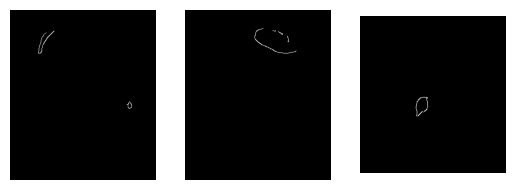

In [366]:
background = []
background_dilated = []
edges_intern = []
for i in range(N):
    background.append(255 - binary_mask[i])
    background_dilated.append(cv.dilate(background[i],cv.getStructuringElement(cv.MORPH_ELLIPSE,(25,25)),iterations = 2))
    edges_intern.append(cv.subtract(edges[i],background_dilated[i]))

plot_images(edges_intern)

Now I want to obtain a binary mask for the defects. 

I use **Closing** morphological operator to "close" the foreground objects (defects). Again, I use a structuring element with an elliptical shape for the reasons explained above.

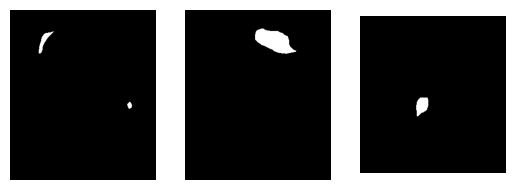

In [367]:
structuringElement = cv.getStructuringElement(cv.MORPH_ELLIPSE, (40, 40))
defects_binary_mask = []
for i in range(N):
    defects_binary_mask.append(cv.morphologyEx(edges_intern[i], cv.MORPH_CLOSE, structuringElement))

plot_images(defects_binary_mask)

Now I have a binary image in which connected components are the defects.

So, to detect how much defects are there in the image, I use the **cv.connectedComponentsWithStats** function that returns the number of connected components, togheter with more information (centroid, bounding box) which i don't need in this case . 

I subract by one because the first connected components is always the background.

In [368]:

for i in range(N):
    (numLabels, _, _, _) = cv.connectedComponentsWithStats(defects_binary_mask[i], 4)
    print("Total defects detected in image{} : {}".format(i,numLabels-1))

Total defects detected in image0 : 2
Total defects detected in image1 : 1
Total defects detected in image2 : 1


Finally, I found the contours of the connected components representing the defects and I higlight them in red.
I use **cv.findContours** function that retrieves contours from a binary image:
- *defects_binary_mask* : the binary image i want to process
- *cv.RETR_TREE* : (mode of the contour retrieval algorithm) retrieves all of the contours and reconstructs a full hierarchy of nested contours.
- *cv.CHAIN_APPROX_NONE*: (the contour approximation algorithm) stores all the contour points.Mayve not all contours points are necessary,if you want to save memory you can use *cv.CHAIN_APPROX_SIMPLE* approximation algorithm. It removes all redundant points and compresses the contour..

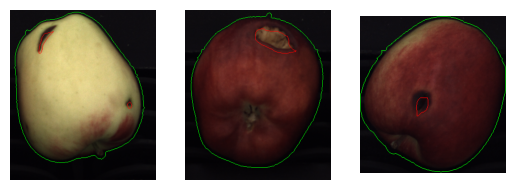

In [371]:
contours = []

for i in range(N):
    contour, _ = cv.findContours(defects_binary_mask[i], cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    contours.append(contour)
    cv.drawContours(rgb_img[i], contours[i], -1, (0,0,255), 1)

plot_images(rgb_img,color=True,rgb=False)



Using *cv.CHAIN_APPROX_NONE* approximation algorithm we cannot see particular differences using this approximation algotihm. So maybe it's better because we can save some memory. 

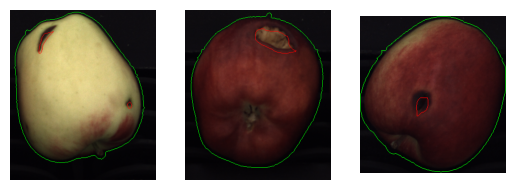

In [372]:
contours = []

for i in range(N):
    contour, _ = cv.findContours(defects_binary_mask[i], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours.append(contour)
    cv.drawContours(rgb_img[i], contours[i], -1, (0,0,255), 1)

plot_images(rgb_img,color=True,rgb=False)